In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load CSV files into Pandas DataFrames
backend_user_df = pd.read_csv('backend_user.csv')  # Replace with your file path
marketplace_studentprofile_df = pd.read_csv('marketplace_studentprofile.csv')  # Replace with your file path
student_application_df = pd.read_csv('student_application_studentapplication.csv')  # Replace with your file path
payment_paymentintent_df = pd.read_csv('payment_paymentintent.csv')  # Replace with your file path

# Perform joins with explicit suffixes
merged_df = pd.merge(
    pd.merge(
        pd.merge(backend_user_df, marketplace_studentprofile_df, left_on='id', right_on='owner_id', suffixes=('_backend', '_profile')),
        student_application_df, left_on='id_profile', right_on='student_id', suffixes=('', '_application')
    ),
    payment_paymentintent_df, left_on='id_profile', right_on='student_issued_to', suffixes=('_app', '_payment')
)

# Drop duplicate columns or select necessary columns
merged_df.drop(['id_profile', 'created_at_profile', 'student_id'], axis=1, inplace=True)

# Access the merged data or perform further operations
print(merged_df.head())  # Adjust as needed

   id_backend                  last_login user_type  is_active  \
0       39141  2023-09-06 06:28:19.283071   student       True   
1       38816  2023-08-29 19:08:16.104834   student       True   
2       38279  2023-11-03 13:32:35.597494   student       True   
3       40055  2023-10-01 16:10:09.405938   student       True   
4       42120  2023-10-23 20:54:58.315899   student       True   

           created_at_backend                 channel channel_at_registration  \
0  2023-02-17 00:53:51.773017             tempadam10p                standard   
1   2023-02-11 16:16:16.21259                standard                standard   
2  2023-01-30 05:59:12.478684  insightcollegeadvising                standard   
3   2023-03-04 04:26:08.33686                standard                standard   
4  2023-03-28 22:04:13.591194                standard                standard   

   registered_with_apple  registered_with_google  owner_id  ...  \
0                  False                   False 

Student enrollment journey for the Core program:
1. Registration
2. Starting and completing an application (13 steps)
3. Talk to an admissions advisor (this might happen before or after completing an
application)
4. Get accepted or rejected
5. If accepted, they are sent an invoice for the “products” or experiences that will
best support their research journey
6. Enrollment (payment)

After a student enrolls, they are paired with an expert mentor to explore their passions through 10 hour-long sessions (data post enrollment is not included in this assignment)


# Registration insights

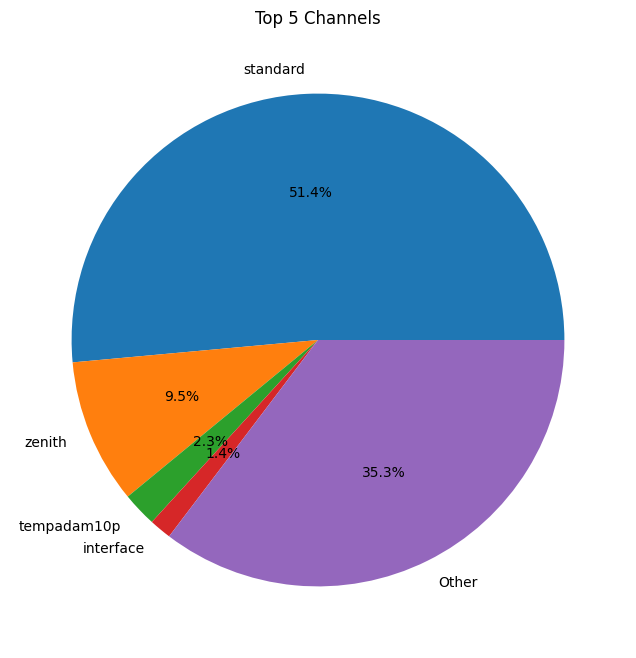

In [79]:
# Get value counts of the column
value_counts = merged_df['channel'].value_counts()

# Extract top 4 records
top_4 = value_counts.head(4)

# Calculate the total of other values
other_total = pd.Series(value_counts.iloc[4:].sum(), index=['Other'])

# Combine top 4 with the total of other values
result = pd.concat([top_4, other_total])

plt.figure(figsize=(8, 8))
plt.pie(result, labels=result.index, autopct='%1.1f%%')
plt.title('Top 5 Channels')
plt.show()

# Starting and completing an application 

In [80]:
merged_df['created_at_backend'] = pd.to_datetime(merged_df['created_at_backend'])

In [81]:
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Extract month from the datetime column and map to seasons
merged_df['season_created_at_backend'] = merged_df['created_at_backend'].dt.month.apply(get_season)

<Axes: xlabel='created_at_backend'>

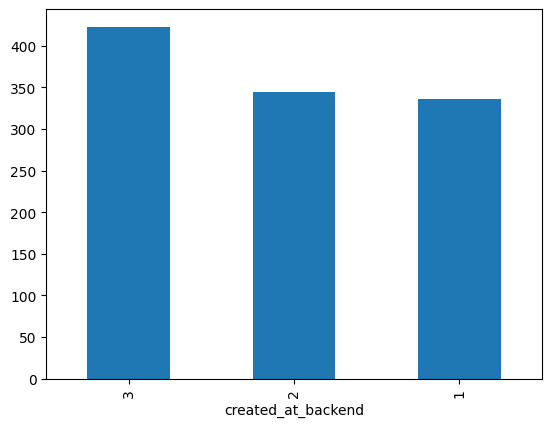

In [82]:
# Candidates register during first quarter only
merged_df['created_at_backend'].dt.month.value_counts().plot(kind='bar')

<Axes: ylabel='count'>

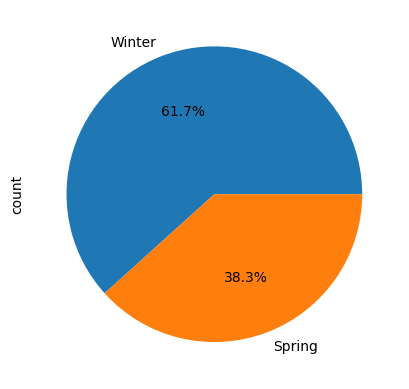

In [83]:
# By season, ~60% of candidates apply in winter
merged_df['season_created_at_backend'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Axes(0.125,0.11;0.775x0.77)
profile_completion_stage
0     26
9      3
13     2
5      1
7      1
3      1
6      1
Name: count, dtype: int64


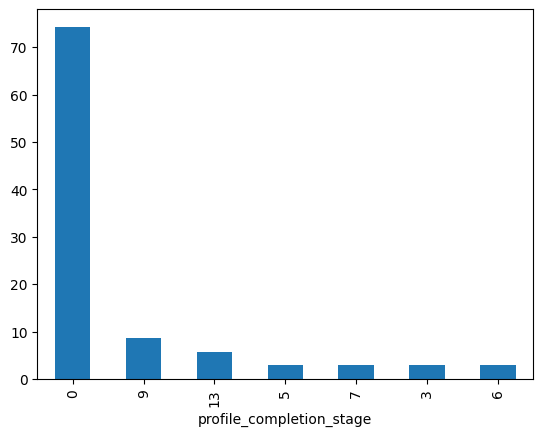

In [84]:
# candidates that have not completed even once
incomplete = merged_df[merged_df['first_completed_at'].isna()]

# candidates X stage for candidates that have not completed once 
print((incomplete['profile_completion_stage'].value_counts()/incomplete['profile_completion_stage'].value_counts().sum() * 100).plot(kind='bar'))
print(incomplete['profile_completion_stage'].value_counts())
# Over 70% of candidates did not start?

Axes(0.125,0.11;0.775x0.77)


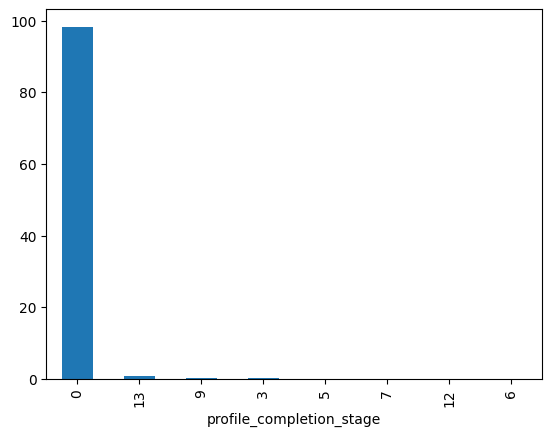

In [95]:
# candidates that have completed atleast once
complete = merged_df[~merged_df['first_completed_at'].isna()]
print((complete['profile_completion_stage'].value_counts()/complete['profile_completion_stage'].value_counts().sum() * 100).plot(kind='bar'))

# Almost all candidates complete their profile and do not make any edits
# Some candidates edit their video interview
# Extremely small fraction of candidates update their student_details and referral - why would someone go out of their way to change their referral source?

In [85]:
# 26 profiles have stage as 0
(incomplete['profile_completion_stage'] == 0).sum()

26

In [86]:
# for stage = 0 incomplete applications, below are the actual stages that they are in - 

# 15 incomplete applications have not even gotten to express general interest
# incomplete[(incomplete['profile_completion_stage'] == 0)]['general_interest'].value_counts(dropna=False)

# 2 incomplete applications are at output stage (5, 11)
# incomplete[(incomplete['profile_completion_stage'] == 0) & ~(incomplete['general_interest'].isna())][outputs]

# 1 incomplete applications is at interests/science_experiment_description stage (6)
# incomplete[(incomplete['profile_completion_stage'] == 0) & ~(incomplete['general_interest'].isna())][['interests','science_experiment_description']]

# 1 incomplete applciation is at time_commitment stage (4)
# incomplete[(incomplete['profile_completion_stage'] == 0) & ~(incomplete['general_interest'].isna())]['time_commitment']

# 5 incomplete applications are at timeline_start_at/timeline_end_at stage (1,2,3,7,8)
# incomplete[(incomplete['profile_completion_stage'] == 0) & ~(incomplete['general_interest'].isna())][['timeline_start_at','timeline_end_at']]

# 2 incomplete applications are at virtual_interview_submitted_at stage
# incomplete[(incomplete['profile_completion_stage'] == 0) & ~(incomplete['general_interest'].isna())]['virtual_interview_submitted_at']


<Axes: xlabel='general_interest'>

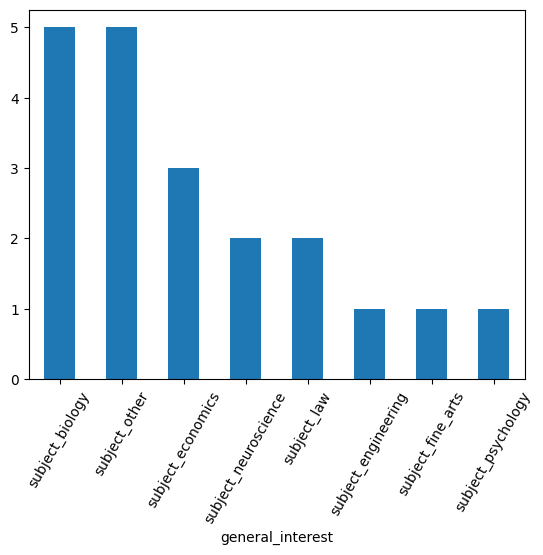

In [87]:
# distribution of general interest amongst incomplete applications
incomplete['general_interest'].value_counts().plot(kind='bar', rot=60)

In [88]:
# incomplete[incomplete['general_interest'] == 'subject_biology'][['interests','science_experiment_description']]

# Below line outputs 5 where last 2 are stuck in 9th (before project_idea) out of which 1 has refunded
incomplete[incomplete['general_interest'] == 'subject_biology']['profile_completion_stage']

In [89]:
# Finding how long incomplete applications have been incomplete
incomplete_durations = pd.DataFrame()
incomplete_durations[['created_at_backend', 'last_login']] = incomplete[['created_at_backend', 'last_login']].apply(pd.to_datetime)
incomplete_durations['duration last-login and created'] = (incomplete_durations['last_login'] - incomplete_durations['created_at_backend']).dt.days
# incomplete[['created_at_app','last_login']]

In [90]:
# incomplete applications that are at most a week old - 8
(incomplete_durations['duration last-login and created'] <= 7).sum() 

# incomplete applications that are > a week but at most 2 weeks old - 0
((incomplete_durations['duration last-login and created'] <= 14) & (incomplete_durations['duration last-login and created'] > 7)).sum() 

# incomplete applications that are > 2 weeks but at most 4 weeks old - 1
((incomplete_durations['duration last-login and created'] <= 28) & (incomplete_durations['duration last-login and created'] > 14)).sum()

# incomplete applications that are > 4 weeks but at most 8 weeks old - 1
((incomplete_durations['duration last-login and created'] <= 56) & (incomplete_durations['duration last-login and created'] > 28)).sum()

# incomplete applications that are > 8 weeks but at most 16 weeks old - 1
((incomplete_durations['duration last-login and created'] <= 112) & (incomplete_durations['duration last-login and created'] > 56)).sum()

# incomplete applications that are > 16 weeks but at most 32 weeks old - 11
((incomplete_durations['duration last-login and created'] <= 224) & (incomplete_durations['duration last-login and created'] > 112)).sum()

# incomplete applications that are > 32 weeks - 10
(incomplete_durations['duration last-login and created'] > 224).sum()

# incomplete applications that have null last login value
incomplete_durations['last_login'].isna().sum()
(incomplete_durations['duration last-login and created'].isna()).sum()

# Large number of incomplete applications are more than 16 weeks old

3

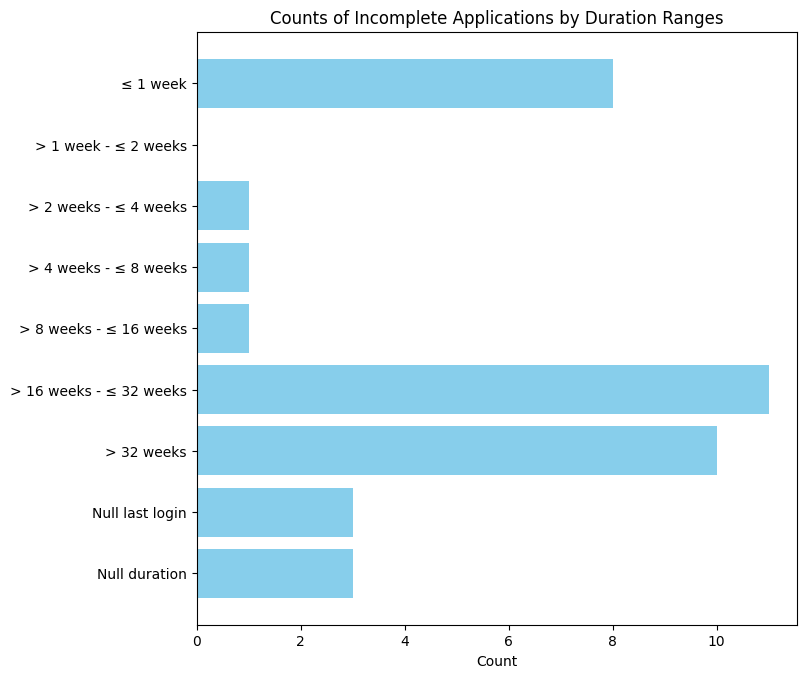

In [375]:
counts = [
    (incomplete_durations['duration last-login and created'] <= 7).sum(),
    ((incomplete_durations['duration last-login and created'] <= 14) & (incomplete_durations['duration last-login and created'] > 7)).sum(),
    ((incomplete_durations['duration last-login and created'] <= 28) & (incomplete_durations['duration last-login and created'] > 14)).sum(),
    ((incomplete_durations['duration last-login and created'] <= 56) & (incomplete_durations['duration last-login and created'] > 28)).sum(),
    ((incomplete_durations['duration last-login and created'] <= 112) & (incomplete_durations['duration last-login and created'] > 56)).sum(),
    ((incomplete_durations['duration last-login and created'] <= 224) & (incomplete_durations['duration last-login and created'] > 112)).sum(),
    (incomplete_durations['duration last-login and created'] > 224).sum(),
    incomplete_durations['last_login'].isna().sum(),
    (incomplete_durations['duration last-login and created'].isna()).sum()
]

# Labels for the categories
labels = [
    '≤ 1 week',
    '> 1 week - ≤ 2 weeks',
    '> 2 weeks - ≤ 4 weeks',
    '> 4 weeks - ≤ 8 weeks',
    '> 8 weeks - ≤ 16 weeks',
    '> 16 weeks - ≤ 32 weeks',
    '> 32 weeks',
    'Null last login',
    'Null duration'
]

# Plotting the bar chart
plt.figure(figsize=(7.75, 7.7))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Counts of Incomplete Applications by Duration Ranges')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [91]:
long_duration_indices = incomplete_durations[incomplete_durations['duration last-login and created'] > 112].index.get_level_values(level=0)
incomplete_long_duration = incomplete.loc[long_duration_indices,]

In [93]:
# Which stage are the incomplete applications, that are quite old, in?
incomplete_long_duration['profile_completion_stage'].value_counts()

profile_completion_stage
0     16
13     2
5      1
7      1
6      1
Name: count, dtype: int64

In [94]:
outputs = [i for i in incomplete.columns if 'output' in i]

print(incomplete[outputs].value_counts())

# incomplete[outputs].value_counts().index

# 20 have not reached the output stage
# 6 incomplete applications are research paper output specific
# 2 incomplete applications are research paper and science_fair_project specific
# 1 incomplete application is science_fair_project specific
# 1 incomplete application is art_work_or_portfolio specific
# 2 incomplete applications are unsure about outputs

output_research_paper  output_github_code_base  output_creative_writing  output_computer_simulation  output_opinion_editorial  output_infographic  output_video_or_docu_series  output_webinar  output_podcast  output_organization  output_art_work_or_portfolio  output_science_fair_project  output_app_game  output_unsure
False                  False                    False                    False                       False                     False               False                        False           False           False                False                         False                        False            False            20
True                   False                    False                    False                       False                     False               False                        False           False           False                False                         False                        False            False             6
                               

In [393]:
complete['first_completed_at'] = pd.to_datetime(complete['first_completed_at'], errors='coerce')

/var/folders/pl/xqlcfhp16mx__n265hhwsrl00000gn/T/ipykernel_3793/3691354150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['first_completed_at'] = pd.to_datetime(complete['first_completed_at'], errors='coerce')


In [406]:
# Finding how long it took for an application to become complete
complete_durations = pd.DataFrame()
complete_durations[['created_at_backend', 'first_completed_at']] = complete[['created_at_backend', 'first_completed_at']].apply(pd.to_datetime)
complete_durations['duration_first_comp_and_created'] = (complete_durations['first_completed_at'] - complete_durations['created_at_backend']).dt.days
# incomplete[['created_at_app','last_login']]

In [404]:
# complete applications that are at most a week old - 625
(complete_durations['duration_first_comp_and_created'] <= 7).sum() 

# # complete applications that are > a week but at most 2 weeks old - 129
((complete_durations['duration_first_comp_and_created'] <= 14) & (complete_durations['duration_first_comp_and_created'] > 7)).sum() 

# # complete applications that are > 2 weeks but at most 4 weeks old - 116
((complete_durations['duration_first_comp_and_created'] <= 28) & (complete_durations['duration_first_comp_and_created'] > 14)).sum()

# # complete applications that are > 4 weeks but at most 8 weeks old - 65
((complete_durations['duration_first_comp_and_created'] <= 56) & (complete_durations['duration_first_comp_and_created'] > 28)).sum()

# # complete applications that are > 8 weeks but at most 16 weeks old - 74
((complete_durations['duration_first_comp_and_created'] <= 112) & (complete_durations['duration_first_comp_and_created'] > 56)).sum()

# # complete applications that are > 16 weeks but at most 32 weeks old - 56
((complete_durations['duration_first_comp_and_created'] <= 224) & (complete_durations['duration_first_comp_and_created'] > 112)).sum()

# # complete applications that are > 32 weeks - 2
(complete_durations['duration_first_comp_and_created'] > 224).sum()

# complete applications that have null last login value
complete_durations['first_completed_at'].isna().sum()
(complete_durations['duration_first_comp_and_created'].isna()).sum()

# Large number of complete applications are done within 1 week

2

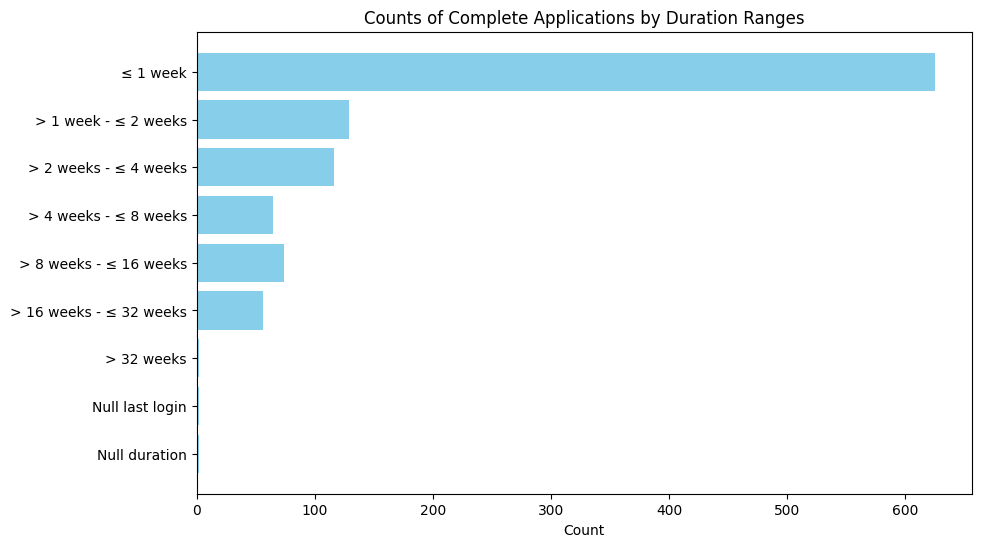

In [405]:
# Counts for different time ranges of complete applications
counts = [625, 129, 116, 65, 74, 56, 2, complete_durations['first_completed_at'].isna().sum(), (complete_durations['duration_first_comp_and_created'].isna()).sum()]

# Labels for the categories
labels = [
    '≤ 1 week',
    '> 1 week - ≤ 2 weeks',
    '> 2 weeks - ≤ 4 weeks',
    '> 4 weeks - ≤ 8 weeks',
    '> 8 weeks - ≤ 16 weeks',
    '> 16 weeks - ≤ 32 weeks',
    '> 32 weeks',
    'Null last login',
    'Null duration'
]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Counts of Complete Applications by Duration Ranges')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [96]:
# After completing their profile, 2 candidates updated their source of referral. Why?
complete[complete['profile_completion_stage'] == 3]['referral']

20     counselor
855        other
Name: referral, dtype: object

Axes(0.22375,0.11;0.5775x0.77)


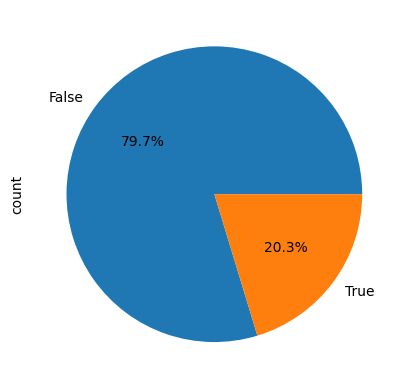

In [97]:
print(complete['intend_to_do_cs'].value_counts().plot(kind='pie', autopct='%1.1f%%'))

In [337]:
complete['referral'].value_counts()

referral
counselor               439
google_search           223
parent                  181
word_of_mouth_friend     75
other                    69
instagram                34
youtube                  16
tiktok                   16
facebook                  8
symposium                 4
influencer                1
twitter                   1
mentor                    1
snapchat                  1
Name: count, dtype: int64

In [345]:
# 700 out of 1069 (65%) completed applications come from organic referrals (in person)
print(complete[complete['referral'].isin(['counselor','parent','word_of_mouth_friend','symposium','mentor'])]['referral'].value_counts().sum())

# 439 come from counselors (62%)
# 181 come from parents (25%)
# 75 come from word of mouth (10%)
# 4 come from symposiums (0.5%)
# 1 comes from a mentor (0.1%)

# 369 out of 1069 (35%) completed applications come from inorganic referrals (internet/social media)
print(complete[~complete['referral'].isin(['counselor','parent','word_of_mouth_friend','symposium','mentor'])]['referral'].value_counts().sum())

# 223 come from google search (60%)
# 69 come from other (18%)
# 34 come from instagram (9%)
# 16 come from youtube (4%)
# 16 come from tiktok (4%)
# 8 comes from facebook (2%)
# 3 come from influencers, twitter and snapchat combined (0.8%)


700
369


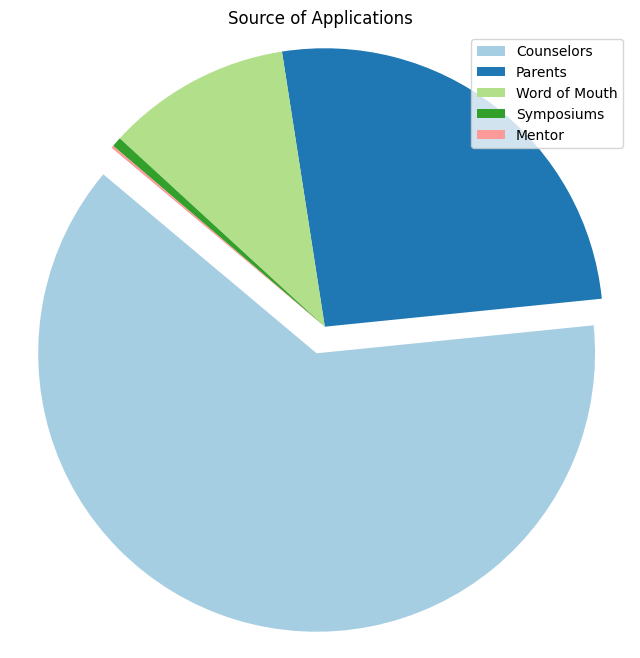

In [380]:
# Data (absolute numbers)
sizes = [439, 181, 75, 4, 1]
labels = ['Counselors', 'Parents', 'Word of Mouth', 'Symposiums', 'Mentor']
explode = (0.1, 0, 0, 0, 0)  # To emphasize the first slice

# Plotting the pie chart with absolute numbers and legend
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=None, startangle=140, explode=explode, colors=plt.cm.Paired.colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Source of Applications')
plt.legend(labels, loc="best")  # Use labels as a legend
plt.show()

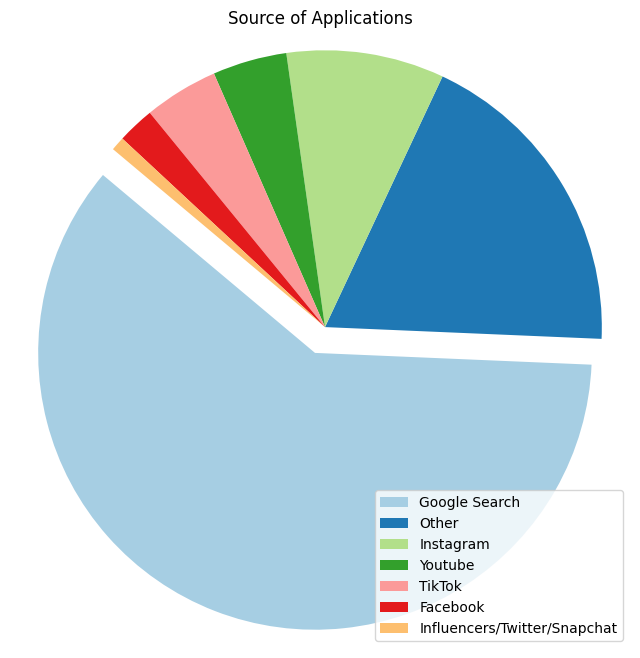

In [382]:
# Data (absolute numbers)
sizes = [223, 69, 34, 16, 16, 8, 3]
labels = ['Google Search', 'Other', 'Instagram', 'Youtube', 'TikTok', 'Facebook', 'Influencers/Twitter/Snapchat']
explode = (0.1, 0, 0, 0, 0, 0, 0)  # To emphasize the first slice

# Plotting the pie chart with absolute numbers and legend
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=None, startangle=140, explode=explode, colors=plt.cm.Paired.colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Source of Applications')
plt.legend(labels, loc="best")  # Use labels as a legend
plt.show()


# Accepted or Rejected insights

In [98]:
merged_df['status_app'].value_counts()

status_app
accepted    676
archived    392
created      35
declined      1
Name: count, dtype: int64

In [99]:
complete['status_app'].value_counts()

status_app
accepted    676
archived    392
declined      1
Name: count, dtype: int64

In [100]:
complete[complete['status_app'] == 'accepted']['status_payment'].value_counts()

status_payment
paid         625
pending       32
refunded      10
requested      6
canceled       3
Name: count, dtype: int64

In [366]:
# Number of accepted applications
acc_app = complete[~complete['accepted_at'].isna()]

In [367]:
# Number of rejected applications
rej_acc = complete[~complete['declined_at'].isna()]

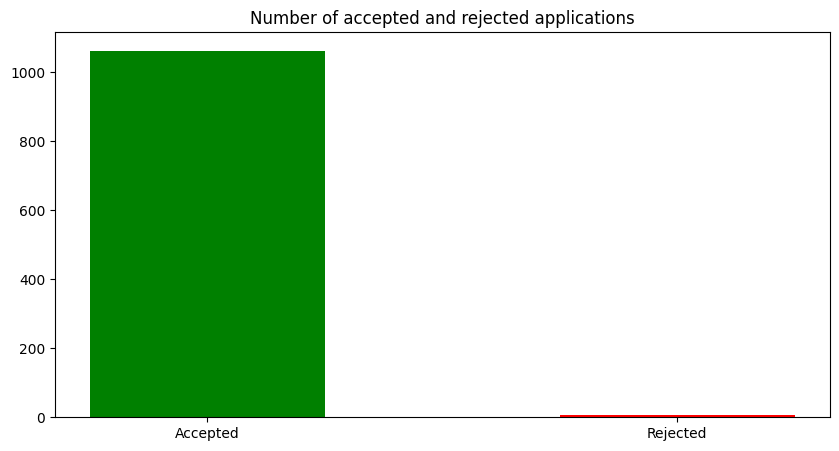

In [413]:
plt.figure(figsize=(10,5))
plt.title('Number of accepted and rejected applications')
plt.bar(['Accepted', 'Rejected'], [len(acc_app), len(rej_acc)], width=0.5, 
        color=['green', 'red'])
plt.show()

In [418]:
print(acc_app['general_interest'].value_counts())
print(acc_app['general_interest'].value_counts()/acc_app['general_interest'].value_counts().sum() * 100)

general_interest
subject_biology         351
subject_engineering     226
subject_economics       152
subject_other           148
subject_law              84
subject_ai               33
subject_fine_arts        24
subject_neuroscience     24
subject_psychology       14
Name: count, dtype: int64
general_interest
subject_biology         33.238636
subject_engineering     21.401515
subject_economics       14.393939
subject_other           14.015152
subject_law              7.954545
subject_ai               3.125000
subject_fine_arts        2.272727
subject_neuroscience     2.272727
subject_psychology       1.325758
Name: count, dtype: float64


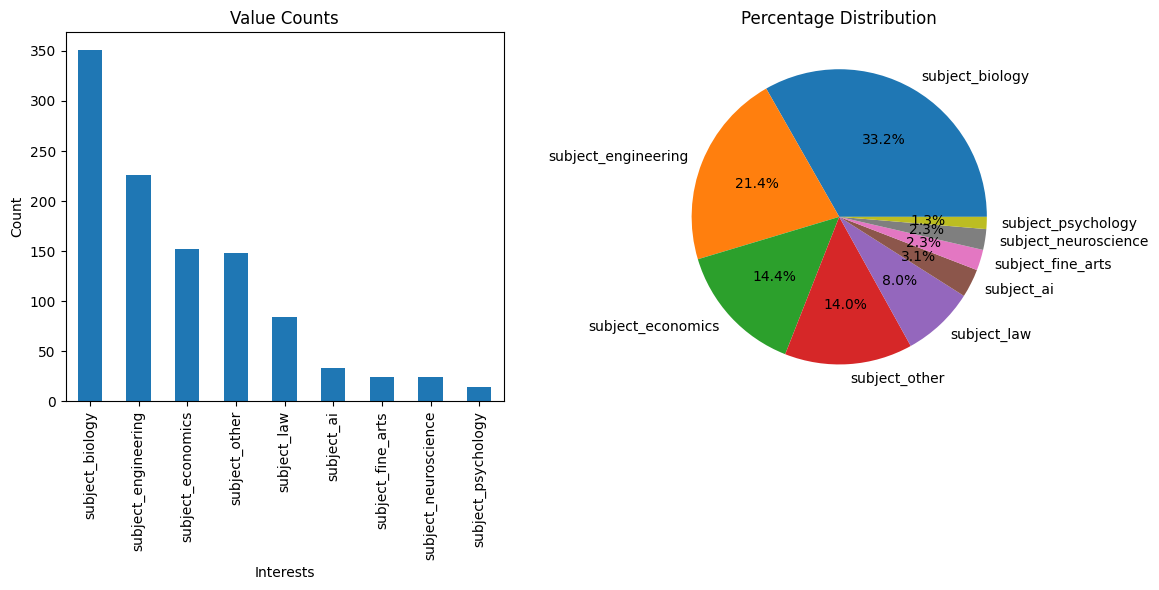

In [422]:
value_counts = acc_app['general_interest'].value_counts()

# Percentage calculation
percentages = value_counts / value_counts.sum() * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot for value counts
value_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Value Counts')
ax1.set_xlabel('Interests')
ax1.set_ylabel('Count')

# Pie chart for percentages
ax2.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
ax2.set_title('Percentage Distribution')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Products invoiced and payment insights

In [104]:
complete['products_invoiced_for'].value_counts()

products_invoiced_for
Flagship project                                                                                                                                        387
Premium Showcasing, Flagship project                                                                                                                     81
Flagship project, Flagship project, Flagship project                                                                                                     71
Flagship project, Premium Showcasing                                                                                                                     66
Flagship project, Flagship project                                                                                                                       41
                                                                                                                                                       ... 
Premium Showcasing, Flagship project, Prem

In [153]:
import numpy as np
def convert_categories_to_columns(df, column_name):
    # Split the categories in each cell, count occurrences, and create a DataFrame
    categories_count = df[column_name].str.split(', ').apply(lambda x: pd.Series(dict(pd.Series(x).value_counts())))

    # Fill NaN values with 0 (for categories not present in some rows)
    categories_count = categories_count.fillna(0).astype(int)

    # Concatenate original DataFrame with the new columns representing category counts
    df = pd.concat([df, categories_count], axis=1)

    # Optionally drop the original column if desired
    # df.drop(columns=column_name, inplace=True)

    return df

In [154]:
encoded_products = complete.copy()
encoded_products = convert_categories_to_columns(encoded_products, 'products_invoiced_for')

/var/folders/pl/xqlcfhp16mx__n265hhwsrl00000gn/T/ipykernel_3793/1338864017.py:4: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  categories_count = df[column_name].str.split(', ').apply(lambda x: pd.Series(dict(pd.Series(x).value_counts())))


In [182]:
total = []
for i in ['Flagship project', 'Mentor Priority', 'Pathfinder (deprecated)','Pathfinder Launchpad', 'Premium Showcasing', 'UCI x GATI']:
    total.append(encoded_products[i].sum())

In [187]:
# 80% of products offered are by 20% of the offerings (paretto principle). Generally normal behviour.
j=0
for i in ['Flagship project', 'Mentor Priority', 'Pathfinder (deprecated)','Pathfinder Launchpad', 'Premium Showcasing', 'UCI x GATI']:
    percentage = total[j]/sum(total) * 100
    formatted_percentage = "{:.2f}".format(percentage)
    print(i, total[j], formatted_percentage)
    j += 1

Flagship project 1830 51.75
Mentor Priority 26 0.74
Pathfinder (deprecated) 38 1.07
Pathfinder Launchpad 99 2.80
Premium Showcasing 1053 29.78
UCI x GATI 490 13.86


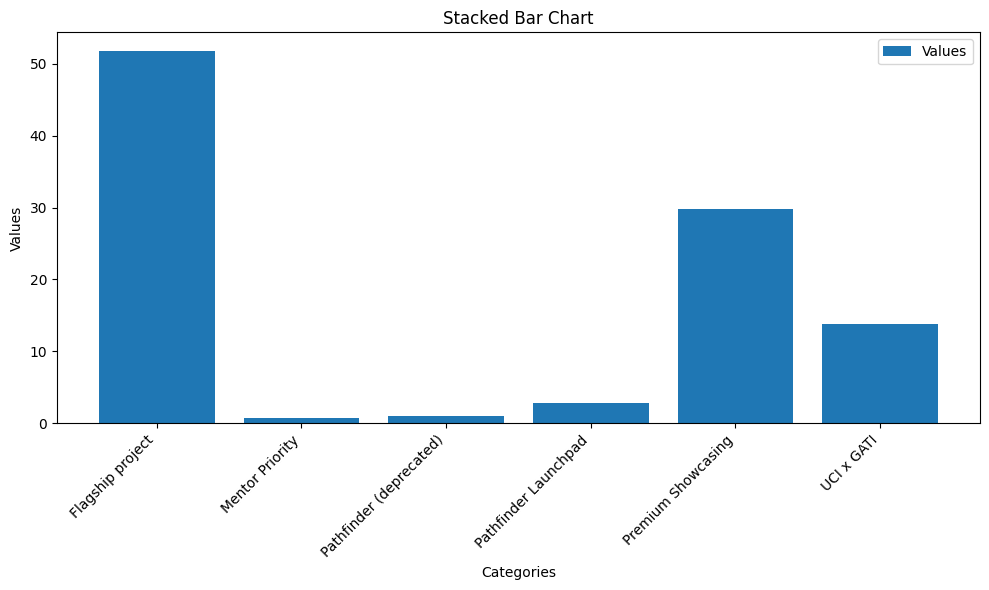

In [423]:
# Data
categories = [
    'Flagship project',
    'Mentor Priority',
    'Pathfinder (deprecated)',
    'Pathfinder Launchpad',
    'Premium Showcasing',
    'UCI x GATI'
]

values = [51.75, 0.74, 1.07, 2.80, 29.78, 13.86]

# Plotting
plt.figure(figsize=(10, 6))

# Creating a stacked bar chart
plt.bar(categories, values, label='Values')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

# Adding a legend
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


<Figure size 1000x1200 with 0 Axes>

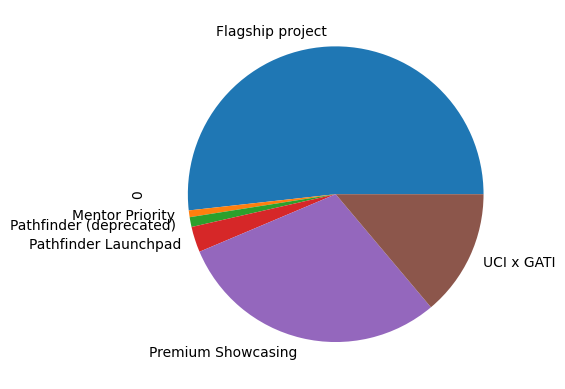

In [425]:
plt.figure(figsize=(10, 12))
pd.DataFrame(total).plot(kind='pie', subplots=True, legend=False, labels=['Flagship project', 'Mentor Priority', 'Pathfinder (deprecated)','Pathfinder Launchpad', 'Premium Showcasing', 'UCI x GATI'])
plt.show()

In [204]:
# Finding total number of products ordered
encoded_products['number_of_products'] = encoded_products['Flagship project'] + encoded_products['Mentor Priority'] + encoded_products['Pathfinder (deprecated)'] + encoded_products['Pathfinder Launchpad'] + encoded_products['Premium Showcasing'] + encoded_products['UCI x GATI']

In [205]:
# If a student gets refunded, the amount_invoice is adjusted for how much needs to be refunded. So total amount invoiced is technically refunded_amount + amount_invoiced
encoded_products['total_amount_invoiced'] = encoded_products['amount_invoiced'] + encoded_products['refunded_amount']

In [206]:
encoded_products['total_amount_invoiced_by_products'] = encoded_products['total_amount_invoiced'] / encoded_products['number_of_products']
encoded_products['amount_invoiced_by_products'] = encoded_products['amount_invoiced'] / encoded_products['number_of_products']

In [207]:
encoded_products[['total_amount_invoiced_by_products','amount_invoiced_by_products']]

,total_amount_invoiced_by_products,amount_invoiced_by_products
0,1572.750000,1572.750000
1,1195.000000,1195.000000
2,1615.166667,1615.166667
3,2695.000000,2695.000000
4,1347.500000,1347.500000
...,...,...
1099,577.222222,577.222222
1100,1455.300000,1455.300000
1101,1747.500000,1747.500000
1102,2910.600000,2910.600000


In [216]:
accepted_applicants_payment = encoded_products.loc[encoded_products['status_app'] == 'accepted', ]

In [347]:
accepted_applicants_payment['status_payment'].value_counts()

status_payment
paid         625
pending       32
refunded      10
requested      6
canceled       3
Name: count, dtype: int64

In [352]:
accepted_applicants_payment.loc[accepted_applicants_payment['total_amount_invoiced_by_products'] != accepted_applicants_payment['amount_invoiced_by_products'], 'status_payment'].value_counts()

status_payment
paid        33
refunded    10
pending      8
Name: count, dtype: int64

In [316]:
len(accepted_applicants_payment)

676

In [354]:
# 51 students that have been accepted, had their amounts refunded (7.5%)
print((accepted_applicants_payment['total_amount_invoiced_by_products'] == accepted_applicants_payment['amount_invoiced_by_products']).value_counts(), '\n',(accepted_applicants_payment['total_amount_invoiced_by_products'] == accepted_applicants_payment['amount_invoiced_by_products']).value_counts()/sum((accepted_applicants_payment['total_amount_invoiced_by_products'] == accepted_applicants_payment['amount_invoiced_by_products']).value_counts())*100)

True     625
False     51
Name: count, dtype: int64 
 True     92.455621
False     7.544379
Name: count, dtype: float64


<Axes: >

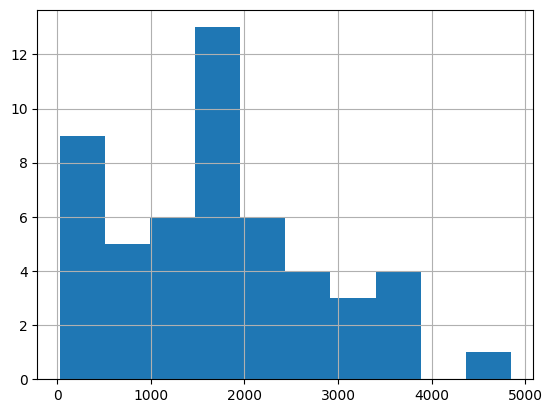

In [314]:
# Accepted applicants that have been refunded an amount, are most associated with a refund between $1500 - $2000 followed by $0 - $500
accepted_applicants_payment[accepted_applicants_payment['refunded_amount'] != 0]['refunded_amount'].hist(bins = 10)

In [325]:
# 39 out of 51 (76.4%) have refunded amounts > 0 and < 2500
accepted_applicants_payment.loc[(accepted_applicants_payment['refunded_amount'] < 2500) & (accepted_applicants_payment['refunded_amount'] > 0), 'refunded_amount']

8       1000.00
10      1700.00
19       720.00
20      1700.00
58      1309.77
79      1700.00
114     2328.48
138     1700.00
149      500.00
163      325.00
231     2148.00
252      350.00
334     1700.00
387     2425.50
398      350.00
407     1700.00
410      295.00
446     1700.00
447     1700.00
451     1700.00
462      720.00
525       30.00
556      800.00
572     1700.00
627      864.00
752     1643.76
762     2022.00
768     1132.38
798      436.50
941     1258.20
962     1206.90
988     1275.48
1029     269.00
1042    1700.00
1046     539.46
1047    1940.40
1052     100.00
1060    2417.50
1062    2195.00
Name: refunded_amount, dtype: float64

In [222]:
# one time vs. subscription 
accepted_applicants_payment['type'].value_counts()

type
one_time        548
subscription    128
Name: count, dtype: int64

In [262]:
onetime_apps = accepted_applicants_payment.loc[accepted_applicants_payment['type'] == 'one_time', ['total_amount_invoiced_by_products','amount_invoiced_by_products']]

In [263]:
onetime_apps.replace([np.inf, -np.inf], np.nan, inplace=True)

(array([ 68., 134., 172.,  79.,  94.]),
 array([1.0000e+00, 6.2990e+02, 1.2588e+03, 1.8877e+03, 2.5166e+03,
        3.1455e+03]),
 <BarContainer object of 5 artists>)

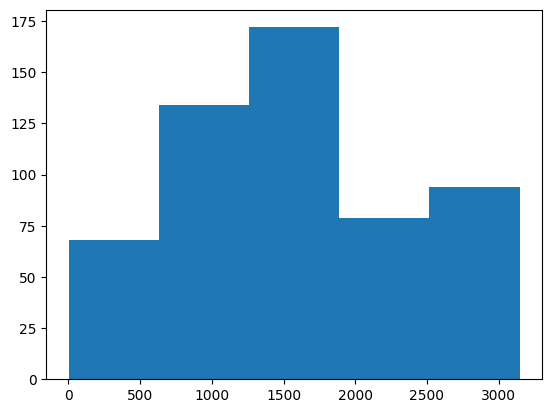

In [264]:
plt.hist(onetime_apps['total_amount_invoiced_by_products'], bins = 5)

(array([ 82., 136., 163.,  76.,  90.]),
 array([   0. ,  629.1, 1258.2, 1887.3, 2516.4, 3145.5]),
 <BarContainer object of 5 artists>)

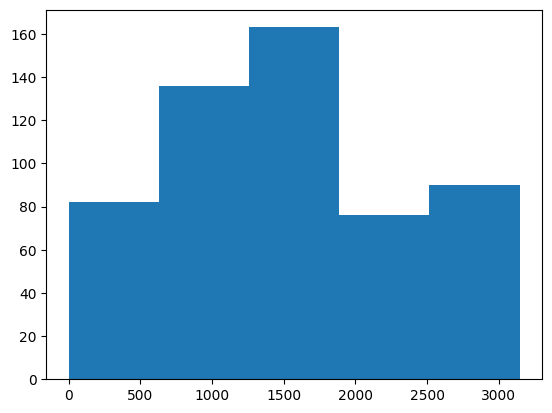

In [265]:
plt.hist(onetime_apps['amount_invoiced_by_products'], bins = 5)

In [266]:
subs_apps = accepted_applicants_payment.loc[accepted_applicants_payment['type'] != 'one_time', ['total_amount_invoiced_by_products','amount_invoiced_by_products']]

In [267]:
subs_apps.replace([np.inf, -np.inf], np.nan, inplace=True)

(array([27., 38., 28., 32.,  3.]),
 array([ 188.73 ,  905.904, 1623.078, 2340.252, 3057.426, 3774.6  ]),
 <BarContainer object of 5 artists>)

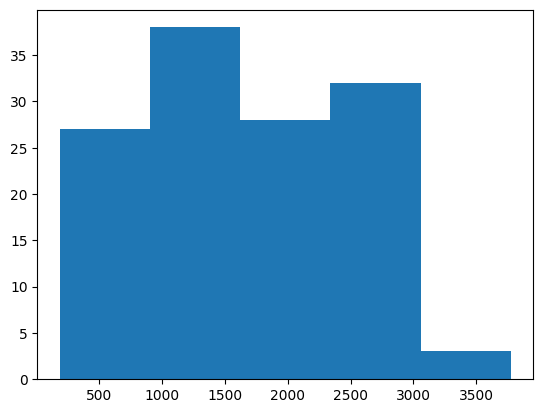

In [268]:
plt.hist(subs_apps['total_amount_invoiced_by_products'], bins = 5)

(array([22., 25., 37., 10., 34.]),
 array([   0.  ,  628.69, 1257.38, 1886.07, 2514.76, 3143.45]),
 <BarContainer object of 5 artists>)

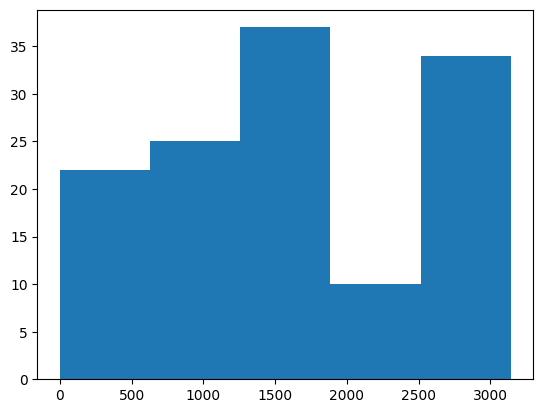

In [269]:
plt.hist(subs_apps['amount_invoiced_by_products'], bins = 5)

In [279]:
# $52 difference in total amount per product amongst subscription and onetime 
print(subs_apps['total_amount_invoiced_by_products'].mean(), onetime_apps['total_amount_invoiced_by_products'].mean())

1664.5809255642362 1612.844175299614


In [280]:
# $29 difference in amount per product amongst subscription and onetime
print(subs_apps['amount_invoiced_by_products'].mean(), onetime_apps['amount_invoiced_by_products'].mean())

1588.062644314236 1559.5535750558602


In [281]:
# $23 difference in amount refunded amongst subscription and onetime
print((subs_apps['total_amount_invoiced_by_products'] - subs_apps['amount_invoiced_by_products']).mean(), (onetime_apps['total_amount_invoiced_by_products'] - onetime_apps['amount_invoiced_by_products']).mean())

76.51828125 53.290600243753815


In [282]:
# Fairly similar distribution of number of products amongst subscription and onetime
print(accepted_applicants_payment.loc[accepted_applicants_payment['type'] == 'one_time', 'number_of_products'].value_counts())
print(accepted_applicants_payment.loc[accepted_applicants_payment['type'] == 'subscription', 'number_of_products'].value_counts())

number_of_products
1     196
2     148
3      91
4      43
6      39
9      25
8       4
0       1
12      1
Name: count, dtype: int64
number_of_products
1     45
2     35
3     16
4     14
6      9
9      7
16     1
8      1
Name: count, dtype: int64


In [290]:
archived_applicants_payment = encoded_products.loc[encoded_products['status_app'] == 'archived',]

In [296]:
len(archived_applicants_payment), len(accepted_applicants_payment)

(392, 676)

In [299]:
# Total number of products shown to accepted and archived applicants are fairly similar
print(accepted_applicants_payment['number_of_products'].sum(), archived_applicants_payment['number_of_products'].sum())

1800 1734


In [427]:
print(accepted_applicants_payment['number_of_products'].mean())

2.662721893491124


In [430]:
print(accepted_applicants_payment['amount_invoiced'].mean())

2977.0822189349115


In [440]:
accepted_applicants_payment['refunded_amount'].median(), accepted_applicants_payment['refunded_amount'].mean()

(0.0, 131.00122781065087)

In [429]:
print(accepted_applicants_payment[['Premium Showcasing', 'Flagship project', 'UCI x GATI','Mentor Priority', 'Pathfinder Launchpad', 'Pathfinder (deprecated)']].sum())

Premium Showcasing          508
Flagship project           1071
UCI x GATI                  138
Mentor Priority              10
Pathfinder Launchpad         51
Pathfinder (deprecated)      22
dtype: int64


In [293]:
archived_applicants_payment[['Premium Showcasing', 'Flagship project', 'UCI x GATI',
       'Mentor Priority', 'Pathfinder Launchpad', 'Pathfinder (deprecated)']].sum()

Premium Showcasing         544
Flagship project           758
UCI x GATI                 352
Mentor Priority             16
Pathfinder Launchpad        48
Pathfinder (deprecated)     16
dtype: int64

In [302]:
# Variation of products offered amongst accepted and archived applicants - Flagship is quite high and UCI x GATI is quite low
print(accepted_applicants_payment[['Premium Showcasing', 'Flagship project', 'UCI x GATI','Mentor Priority', 'Pathfinder Launchpad', 'Pathfinder (deprecated)']].sum() 
- archived_applicants_payment[['Premium Showcasing', 'Flagship project', 'UCI x GATI','Mentor Priority', 'Pathfinder Launchpad', 'Pathfinder (deprecated)']].sum())

Premium Showcasing         -36
Flagship project           313
UCI x GATI                -214
Mentor Priority             -6
Pathfinder Launchpad         3
Pathfinder (deprecated)      6
dtype: int64


In [292]:
archived_applicants_payment[['total_amount_invoiced_by_products','amount_invoiced_by_products']]

,total_amount_invoiced_by_products,amount_invoiced_by_products
22,873.750000,873.750000
26,925.500000,925.500000
36,2500.000000,2500.000000
39,2910.600000,2910.600000
46,582.500000,582.500000
...,...,...
1081,849.285000,849.285000
1082,577.222222,577.222222
1085,2695.000000,2695.000000
1087,2910.600000,2910.600000


In [363]:
# 16056, 10874, 16057, 10879 are admissions advisors that have overseen most of the completed applications
complete['admission_advisor_id'].value_counts()

admission_advisor_id
16056.0    250
10874.0    243
16057.0    243
10879.0    190
28466.0     49
12307.0     32
43901.0     17
43913.0     11
11633.0      9
37428.0      6
3488.0       4
1404.0       4
37427.0      1
Name: count, dtype: int64

In [369]:
# completed applications that were accepted have similar distribution of overseeing advisors
acc_app['admission_advisor_id'].value_counts()

admission_advisor_id
16056.0    248
16057.0    243
10874.0    240
10879.0    190
28466.0     48
12307.0     32
43901.0     17
43913.0     10
11633.0      9
37428.0      6
3488.0       4
1404.0       4
37427.0      1
Name: count, dtype: int64